In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 08c

## Working with Tensorflow 
- One hidden layer
- ${Swish}$ activation function
- Adam
- Multi-class output
- FIFA dataset
- use of datasets

<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

# from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models' # location of the images
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well


EPOCHS = 100 # number of epochs
ALPHA = 0.1 # learning rate

BATCH_SIZE = 256

TEST_SIZE = 0.2

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'medium',
          'figure.figsize'  : (15,15),
          'axes.labelsize'  : 'large',
          'axes.titlesize'  :'large',
          'xtick.labelsize' :'medium',
          'ytick.labelsize' :'medium',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [4]:

###----------------------
### Plot confusion matrix
###----------------------
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    '''
    
    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (6,6))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();

In [5]:
###------------------------------------------------
### Plot Loss Curve using Tensorflow history object
###------------------------------------------------
def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

## Basic Hygiene

In [6]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))
    

In [7]:
### Settings so that Tensorflow can not Hog all the GPU memory
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Read FIFA 2019 data set

In [8]:
data_df = pd.read_csv( 'fifa_2019.csv')
data_df.shape

(18207, 89)

In [9]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [10]:
# Following columns appear to be relevant for our analysis
rel_cols = ['Position', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [11]:
# Are there NaNs Still?

data_df.isna().sum()

Position           0
Finishing          0
HeadingAccuracy    0
ShortPassing       0
Volleys            0
Dribbling          0
Curve              0
FKAccuracy         0
LongPassing        0
BallControl        0
Acceleration       0
SprintSpeed        0
Agility            0
Reactions          0
Balance            0
ShotPower          0
Jumping            0
Stamina            0
Strength           0
LongShots          0
Aggression         0
Interceptions      0
Positioning        0
Vision             0
Penalties          0
Composure          0
Marking            0
StandingTackle     0
SlidingTackle      0
GKDiving           0
GKHandling         0
GKKicking          0
GKPositioning      0
GKReflexes         0
dtype: int64

In [12]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [13]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [14]:
class_labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [15]:
y = data_df["Position"].to_numpy()

X = data_df.drop("Position", axis = 1)

In [16]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14517, 33) (14517,) (3630, 33) (3630,)


In [17]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [18]:
type(X_train), type(X_test), type(y_train),type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

## Converting to Datasets

In [19]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test))

### Preprocessing and Batching

Apply various transformations, such as shuffling and batching, to the dataset:

In [20]:
# Shuffle and batch the dataset
train_ds = train_ds.shuffle(buffer_size=X_train.shape[0]).batch(BATCH_SIZE)
test_ds = test_ds.shuffle(buffer_size=X_test.shape[0]).batch(BATCH_SIZE)

In [21]:
## Optimize for performance

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
for features, labels in train_ds.take(1):
    print (features.shape, labels.shape)

(256, 33) (256,)


## Prepare model

### Functional API

<p style="font-family: Arial; font-size:1.2em;">You can also instantiate a Model with the <strong>"Functional API"</strong>, where you start from Input, you chain layer calls to specify the model's forward pass, and finally you create your model from inputs and outputs:

In [23]:
inputs = tf.keras.Input(shape=(33,))
    
x = tf.keras.layers.Dense(18, activation=tf.nn.relu)(inputs)

outputs = tf.keras.layers.Dense(4)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [24]:
predictions = model(features).numpy()
predictions.shape

(256, 4)

In [25]:
predictions[0].sum()

1.6006727

The `tf.nn.softmax` function converts these logits to "probabilities" for each class: 

In [26]:
tf.nn.softmax(predictions).numpy()[0]

array([0.28588495, 0.2996    , 0.03217306, 0.38234198], dtype=float32)

In [27]:
tf.nn.softmax(predictions).numpy().sum(axis = 1)[0]

1.0

In [28]:
'''
Number of parameters:
    layer 1 : 33*18 +18 = 612 
    layer 2 : 18*4 + 4
We are not locking any layer hence all parameter are trainable    
'''

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33)]              0         
                                                                 
 dense (Dense)               (None, 18)                612       
                                                                 
 dense_1 (Dense)             (None, 4)                 76        
                                                                 
Total params: 688 (2.69 KB)
Trainable params: 688 (2.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy ( from_logits = True)

In [30]:
labels

<tf.Tensor: shape=(256,), dtype=int8, numpy=
array([0, 3, 2, 1, 2, 1, 2, 2, 2, 1, 1, 3, 3, 2, 0, 1, 0, 2, 2, 2, 0, 1,
       3, 3, 2, 3, 3, 3, 0, 2, 0, 2, 2, 1, 3, 3, 0, 2, 1, 1, 0, 0, 2, 3,
       2, 1, 2, 3, 1, 1, 1, 2, 1, 1, 1, 0, 2, 1, 1, 1, 2, 0, 3, 2, 3, 1,
       2, 3, 0, 2, 1, 1, 2, 3, 2, 2, 1, 1, 1, 2, 2, 1, 0, 1, 1, 2, 2, 1,
       1, 0, 2, 2, 1, 0, 2, 2, 1, 2, 2, 3, 3, 1, 1, 2, 2, 3, 3, 1, 0, 2,
       2, 3, 3, 2, 3, 1, 1, 0, 3, 1, 2, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 1,
       3, 2, 3, 1, 1, 2, 2, 2, 1, 2, 1, 0, 1, 0, 0, 1, 2, 2, 1, 2, 2, 1,
       1, 3, 1, 2, 0, 1, 1, 3, 2, 1, 2, 2, 2, 0, 3, 2, 2, 1, 2, 0, 2, 2,
       1, 2, 2, 2, 0, 2, 2, 3, 2, 1, 3, 2, 1, 2, 1, 2, 2, 3, 2, 2, 0, 2,
       1, 1, 1, 2, 0, 2, 1, 1, 1, 2, 1, 0, 2, 1, 2, 3, 1, 3, 1, 0, 3, 2,
       2, 1, 3, 2, 1, 1, 1, 2, 3, 2, 3, 2, 1, 2, 2, 2, 2, 1, 0, 2, 1, 1,
       2, 2, 1, 0, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2], dtype=int8)>

In [31]:
loss_fn(labels, predictions).numpy()

1.4437308

Using `model.compile`, specify the training configuration such as:
- Loss function to minimize
- Optimizer
- List of metrics to monitor

In [32]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

Call `fit()`, which will train the model by slicing the data into `batches` of size `batch_size`, and repeatedly iterating over the entire dataset for a given number of `epochs`. Pass some validation for monitoring validation loss and metrics at the end of each epoch.

In [33]:
history = model.fit(train_ds, 
                    validation_data=test_ds,
                    epochs=EPOCHS)

Epoch 1/100


57/57 [==============================] - 1s 8ms/step - loss: 0.9383 - accuracy: 0.5395 - val_loss: 0.6721 - val_accuracy: 0.7163
Epoch 2/100
57/57 [==============================] - 0s 3ms/step - loss: 0.5731 - accuracy: 0.7690 - val_loss: 0.4967 - val_accuracy: 0.7978
Epoch 3/100
57/57 [==============================] - 0s 3ms/step - loss: 0.4569 - accuracy: 0.8150 - val_loss: 0.4294 - val_accuracy: 0.8163
Epoch 4/100
57/57 [==============================] - 0s 3ms/step - loss: 0.4069 - accuracy: 0.8341 - val_loss: 0.3968 - val_accuracy: 0.8264
Epoch 5/100
57/57 [==============================] - 0s 4ms/step - loss: 0.3796 - accuracy: 0.8450 - val_loss: 0.3764 - val_accuracy: 0.8350
Epoch 6/100
57/57 [==============================] - 0s 4ms/step - loss: 0.3614 - accuracy: 0.8527 - val_loss: 0.3615 - val_accuracy: 0.8388
Epoch 7/100
57/57 [==============================] - 0s 4ms/step - loss: 0.3480 - accuracy: 0.8602 - val_loss: 0.3501 - val_accuracy: 0.8468
Epoch 8/100

In case we want to separately evaluate this model, we have `evaluate` function.

In [34]:
model.evaluate ( test_ds, verbose=2)

15/15 - 0s - loss: 0.2987 - accuracy: 0.8733 - 50ms/epoch - 3ms/step


[0.298727422952652, 0.8732782602310181]

In [35]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.938336,0.539505,0.672081,0.716253
1,0.573083,0.769029,0.496690,0.797796
2,0.456862,0.814976,0.429356,0.816253
3,0.406947,0.834057,0.396840,0.826446
4,0.379582,0.845009,0.376392,0.834986


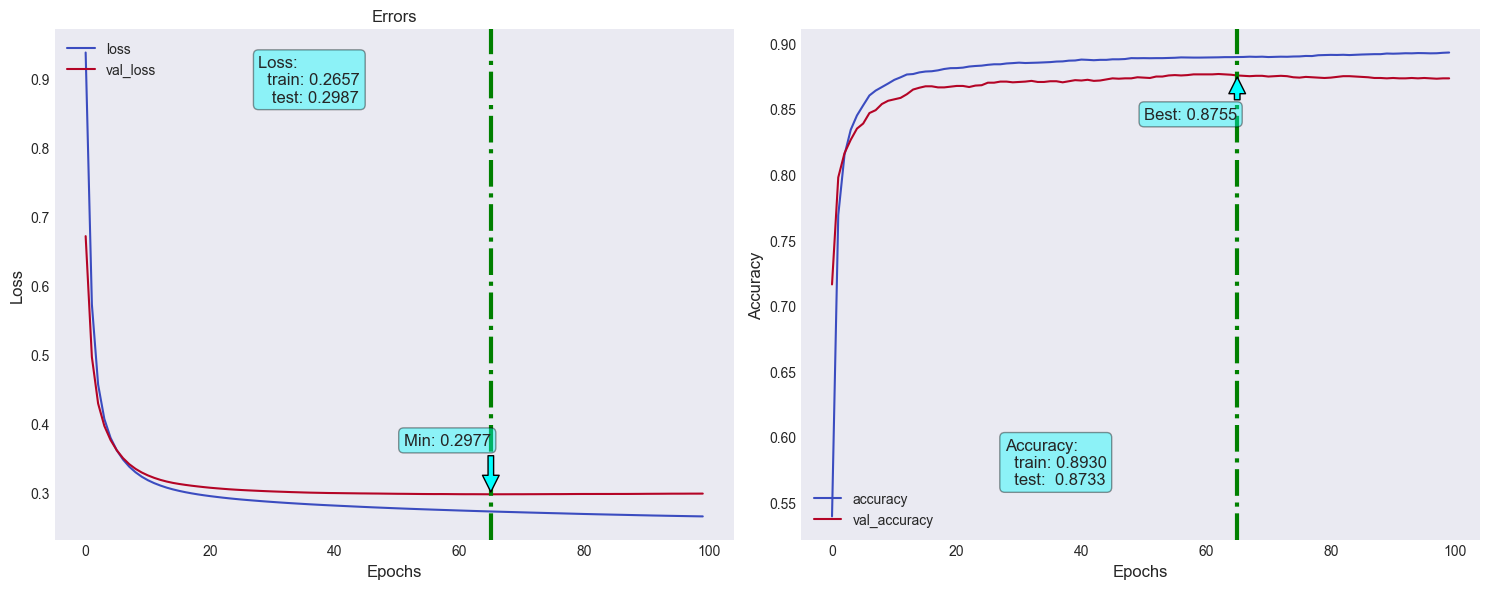

In [36]:
fn_plot_tf_hist(loss_df)

In [37]:
loss_df[loss_df['val_loss'] == loss_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy
65,0.272828,0.889509,0.297745,0.875482


## Predictions

In [38]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [39]:
y_pred = probability_model(X_train).numpy()
y_pred.shape

(14517, 4)

In [40]:
print(classification_report( y_train, y_pred.argmax( axis = 1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.92      0.93      0.93      4693
           2       0.85      0.88      0.86      5470
           3       0.87      0.79      0.83      2734

    accuracy                           0.89     14517
   macro avg       0.91      0.90      0.90     14517
weighted avg       0.89      0.89      0.89     14517



In [41]:
y_pred = probability_model(X_test).numpy()

print('Accuracy score on Test Data :{:.5f}'.format(accuracy_score(y_test, 
                                                                  np.argmax(y_pred, axis = 1))))

Accuracy score on Test Data :0.87328


In [42]:
print(classification_report(y_test, 
                            np.argmax(y_pred, axis = 1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.92      0.92      0.92      1173
           2       0.82      0.86      0.84      1368
           3       0.83      0.74      0.78       684

    accuracy                           0.87      3630
   macro avg       0.89      0.88      0.89      3630
weighted avg       0.87      0.87      0.87      3630



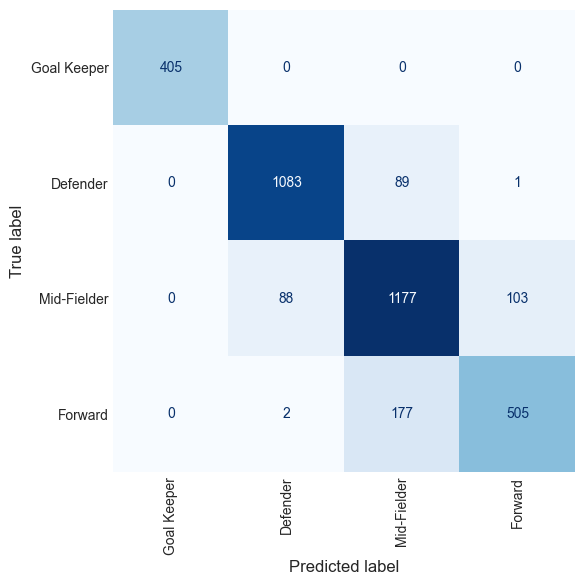

In [43]:
fn_plot_confusion_matrix( y_test, y_pred.argmax( axis = 1), labels=class_labels)

In [45]:
probability_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])

In [46]:
y_true, pred = [],[]
for features,labels in train_ds:
    y_pred = probability_model(features).numpy()
    pred.extend(y_pred)
    y_true.extend(labels)
y_pred.shape

(181, 4)